In [1]:
from __future__ import annotations

import abc
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from tqdm.autonotebook import tqdm

# Conditional Diffusion Models On MNIST

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data Loading

In [3]:
mnist_train_ds = torchvision.datasets.MNIST(
    'mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ]))

mnist_test_ds = torchvision.datasets.MNIST(
    'mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ]))

## Diffusion Models
### Forward Process

In [4]:
class BetaScheduler(abc.ABC):
    def __init__(self, beta_start: float, beta_end: float, time_steps: int) -> None:
        self._time_steps = time_steps
        self._beta = self._schedule_beta(beta_start, beta_end, time_steps)
        self._alpha = 1. - self._beta
        self._alpha_bar = torch.cumprod(self._alpha, dim=0)
        self._1_minus_alpha_bar = 1. - self._alpha_bar
        self._sqrt_alpha_bar = torch.sqrt(self._alpha_bar)
        self._sqrt_1_minus_alpha_bar = torch.sqrt(self._1_minus_alpha_bar)

    @property
    def max_time_steps(self):
        return self._time_steps

    def beta(self, time_steps: torch.Tensor):
        return self._get_values_at(self._beta, time_steps)

    def alpha(self, time_steps: torch.Tensor):
        return self._get_values_at(self._alpha, time_steps)

    def one_minus_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._1_minus_alpha_bar, time_steps)

    def sqrt_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._sqrt_alpha_bar, time_steps)

    def sqrt_1_minus_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._sqrt_1_minus_alpha_bar, time_steps)

    @abc.abstractmethod
    def _schedule_beta(self, beta_start: float, beta_end: float, time_steps: int) -> torch.Tensor:
        pass

    def _get_values_at(self, values: torch.Tensor, time_steps: torch.Tensor) -> torch.Tensor:
        """
        Obtain values at given time steps.

        Parameters
        ==========
        values: torch.Tensor
            A tensor of shape (T,) containing values to be extracted at each time step.
        time_steps: torch.Tensor
            Time steps to be extracted, can be a tensor of shape (N, ) or a scalar tensor.
        """
        if len(time_steps.shape) == 0:
            return values[time_steps]

        v = torch.gather(values, 0, time_steps)
        return v[:, None]


class LinearBetaScheduler(BetaScheduler):
    def _schedule_beta(self, beta_start: float, beta_end: float, time_steps: int) -> torch.Tensor:
        return torch.linspace(beta_start, beta_end, time_steps)


class ConditionalDiffusionForwardProcess:
    def __init__(self, beta_scheduler: BetaScheduler) -> None:
        self._beta_scheduler = beta_scheduler

    def __call__(self, img: torch.Tensor, time_steps: torch.Tensor):
        return self.forward(img, time_steps)

    @property
    def max_time_steps(self):
        return self._beta_scheduler.max_time_steps

    @torch.no_grad()
    def forward(self, img: torch.Tensor, time_steps: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform diffusion forward process based on the nice property:
        q(x_t | x_0) = Normal(x_t; \sqrt{\bar{\alpha_t}}x_0, (1 - \bar{\alpha_t})I

        Parameters
        ==========
        img: torch.Tensor
            The original image (x_0), can be unbatched input (C, H, W) or batched input (N, C, H, W).
        time_steps: torch.Tensor
            The number of time steps (t) to perform forward process, can be a tensor of 1 value for unbatched |img|
            or a tensor (N,) for batched |img|.
        """
        is_batched_input = len(img.shape) == 4
        if is_batched_input:
            assert img.shape[0] == time_steps.shape[0]
        else:
            img = img[None, ...]
            time_steps = time_steps[None, ...]

        # Generate random noise.
        noise = torch.randn_like(img)

        # Generate noisy images.
        sqrt_alpha_bar = self._beta_scheduler.sqrt_alpha_bar(time_steps)[..., None, None]
        sqrt_1_minus_alpha_bar = self._beta_scheduler.sqrt_1_minus_alpha_bar(time_steps)[..., None, None]
        noisy_img = sqrt_alpha_bar * img + noise * sqrt_1_minus_alpha_bar

        return (noisy_img, noise) if is_batched_input else (noisy_img[0], noise[0])

Now, we will check if our forward process is working as intended.
We should see that as the time steps getting larger, our images become more and more noisy,
and eventually become random noises.

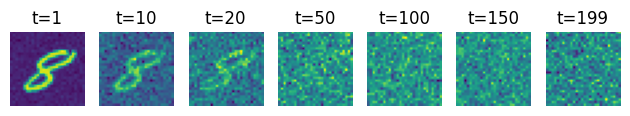

In [5]:
beta_scheduler = LinearBetaScheduler(1e-4, 0.2, 200)
forward_process = ConditionalDiffusionForwardProcess(beta_scheduler)

time_steps = [1, 10, 20, 50, 100, 150, 199]
fig, axes = plt.subplots(ncols=len(time_steps))
for ax, t in zip(axes, time_steps):
    img, _ = mnist_train_ds[2555]
    noisy_img, _ = forward_process.forward(img, torch.tensor(t))
    ax.imshow(noisy_img[0])
    ax.axis('off')
    ax.set_title(f'{t=}')

fig.tight_layout()

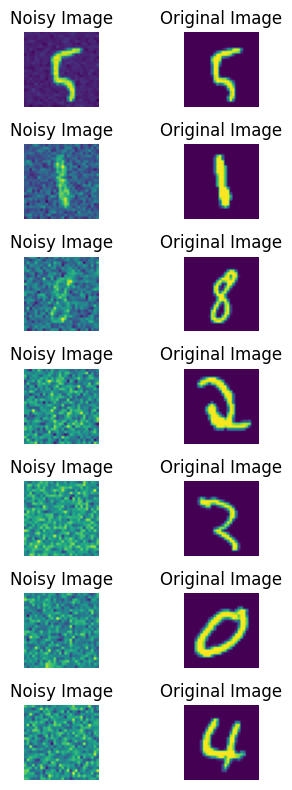

In [6]:
img_idx = [100, 200, 300, 400, 500, 577, 988]
images = torch.concat([mnist_train_ds[i][0][None, ...] for i in img_idx], dim=0)
noisy_images, _ = forward_process.forward(images, torch.tensor(time_steps))
fig, axes = plt.subplots(nrows=len(time_steps), ncols=2, figsize=(4, 8))
for i, (noisy_img, original_img, t) in enumerate(zip(noisy_images, images, time_steps)):
    ax = axes[i, 0]
    ax.imshow(noisy_img[0])
    ax.axis('off')
    ax.set_ylabel(f'{t=}')
    ax.set_title('Noisy Image')

    ax = axes[i, 1]
    ax.imshow(original_img[0])
    ax.axis('off')
    ax.set_title('Original Image')

fig.tight_layout()

### Backward Process
#### Diffusion Backward-Process Neural Network

For the decoder network, we will just use a simple fully-connected model.
Because in this, we will focus on how the diffusion process works.

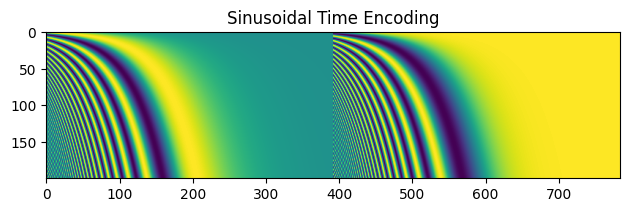

In [7]:
class SinusoidalPositionEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        encodings = torch.log(torch.tensor(10000)) / (half_dim - 1)
        encodings = torch.exp(torch.arange(half_dim, device=device) * -encodings)
        encodings = time[:, None] * encodings[None, :]
        encodings = torch.cat((encodings.sin(), encodings.cos()), dim=-1)
        return encodings


time_encoder = SinusoidalPositionEncoding(28 * 28)
time_steps = torch.arange(0, 200)
encoding = time_encoder(time_steps)
plt.figure()
plt.title('Sinusoidal Time Encoding')
plt.imshow(encoding)
plt.tight_layout()

In [8]:
class MNISTConditionalDiffusionBackwardNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.flatten = nn.Flatten()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEncoding(28 * 28),
            nn.Linear(28*28, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )
        self.first = nn.Sequential(
            nn.Linear(28*28 + 10, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
            # nn.Dropout(1),
        )

        self.hidden = nn.Sequential(
            # nn.LayerNorm(2048),
            # nn.BatchNorm1d(2048),
            # Encoder.
            nn.Linear(2048, 1024), nn.LayerNorm(1024), nn.SiLU(),
            # nn.Linear(1024, 512), nn.LayerNorm(512), nn.SiLU(),
            # nn.Linear(512, 256), nn.LayerNorm(256), nn.SiLU(),
            # nn.Linear(256, 128), nn.LayerNorm(128), nn.SiLU(),
            # # Decoder.
            # nn.Linear(128, 256), nn.LayerNorm(256), nn.SiLU(),
            # nn.Linear(256, 512), nn.LayerNorm(512), nn.SiLU(),
            # nn.Linear(512, 1024), nn.LayerNorm(1024), nn.SiLU(),
            nn.Linear(1024, 2048), nn.LayerNorm(2048), nn.SiLU(),
            nn.Linear(2048, 28 * 28),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))

    def forward(self, x: torch.Tensor, *, time_steps: torch.Tensor, class_labels: torch.Tensor, class_masks: torch.Tensor):
        device = x.device
        batch_size = x.shape[0]
    
        # Create one-hot encoding.
        one_hot = torch.where(
            class_masks[..., None],
            torch.zeros((batch_size, 10), device=device),
            F.one_hot(class_labels, num_classes=10).to(device))

        x = self.flatten(x)
    
        # Append to the original random noises.
        x = torch.concat((x, one_hot), dim=1)

        x = self.first(x)
        x += self.time_mlp(time_steps)
        x = self.hidden(x)
        x = self.unflatten(x)
        return x

#### Backward Process

In backward process, the neural network is used to model the noise added.

To bad, we can really test whether our backward process is correct right now.
We will have to wait until we trained the model.
Oh well!

### Training Process
#### Loss Function

In [9]:
def diffusion_loss(pred_noise, target_noise):
    # return F.mse_loss(pred_noise, target_noise)
    return F.smooth_l1_loss(pred_noise, target_noise)

#### Training and Evaluation Procedure

In [10]:
class MNISTConditionalDiffusionTrainingProcedure:
    def __init__(
            self,
            model: MNISTConditionalDiffusionBackwardNetwork,
            forward_process: ConditionalDiffusionForwardProcess,
            device: str,
            unconditional_prob: float = 0.1,
            lr: float = 1e-3) -> None:
        self._model = model.to(device)
        self._forward_process = forward_process
        self._device = device

        # The unconditional probability.
        self._unconditional_prob = unconditional_prob

        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=lr)
        model.apply(lambda m: self._init_weights(m))
        
    def _init_weights(self, m: nn.Module):
        strategy_fn = nn.init.xavier_normal_
        if type(m) in [nn.Linear]:
            strategy_fn(m.weight)

    def train(self, dataloader: DataLoader[torchvision.datasets.MNIST], epoch: int) -> float:
        self._model.train()

        nb_batches = len(dataloader)
        total_loss = 0.
        for i, (X, y) in tqdm(enumerate(dataloader), total=nb_batches, desc=f'Training epoch {epoch}'):
            loss = self._forward_step(X, class_labels=y, unconditional_prob=self._unconditional_prob) #, show=(i == 0))
            total_loss += float(loss.item())

            # Perform gradient descent.
            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()

        return total_loss / nb_batches

    @torch.no_grad()
    def evaluate(self, dataloader: DataLoader[torchvision.datasets.MNIST]) -> float:
        self._model.eval()

        nb_batches = len(dataloader)
        total_loss = 0.
        for X, y in tqdm(dataloader, total=nb_batches, desc='Evaluating'):
            total_loss += float(self._forward_step(X, class_labels=y).item())

        return total_loss / nb_batches

    def _forward_step(
            self,
            X: torch.Tensor,
            class_labels: torch.Tensor,
            unconditional_prob: float | None = None,
            show=False):
        # Generate noisy images.
        batch_size = X.shape[0]
        random_time_steps = torch.randint(0, self._forward_process.max_time_steps, size=(batch_size,))
        noisy_X, added_noise = self._forward_process.forward(X, random_time_steps)

        # Generate class masks.
        if unconditional_prob is None:
            unconditional_prob = self._unconditional_prob

        class_masks = torch.rand((batch_size,), device=self._device) > unconditional_prob

        # Move the tensors to the desired device.
        noisy_X, added_noise = noisy_X.to(self._device), added_noise.to(self._device)
        random_time_steps = random_time_steps.to(self._device)

        # Feed the noisy images to model to get back predicted noise.
        pred_noise = self._model(
            noisy_X,
            time_steps=random_time_steps,
            class_labels=class_labels,
            class_masks=class_masks)

        if show:
            fig, axes = plt.subplots(ncols=2)
            cs = axes[0].imshow(pred_noise[0].cpu().detach().numpy()[0])
            axes[0].set_title('Predicted Noise')
            fig.colorbar(cs, ax=axes[0])
            cs = axes[1].imshow(added_noise[0].cpu().detach().numpy()[0])
            axes[1].set_title('Original Noise')
            fig.colorbar(cs, ax=axes[1])
            fig.tight_layout()
            plt.show()

        # Calculate the loss.
        loss = diffusion_loss(pred_noise, added_noise)
        # loss = diffusion_loss_normal(pred_noise, added_noise)
        return loss

### Model Training

In [11]:
mnist_train_dataloader = DataLoader(mnist_train_ds, batch_size=256, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test_ds, batch_size=256)

In [12]:
UNCONDITIONAL_PROB = 0.1
model = MNISTConditionalDiffusionBackwardNetwork()
training_procedure = MNISTConditionalDiffusionTrainingProcedure(
    model, forward_process, device,
    unconditional_prob=UNCONDITIONAL_PROB,
    lr=1e-3)

epochs = 1 if device == 'cpu' else 200
train_losses = []
test_losses = []
for epoch in range(epochs):
    train_loss = training_procedure.train(mnist_train_dataloader, epoch)
    test_loss = training_procedure.evaluate(mnist_test_dataloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'{train_loss=:.4f} {test_loss=:.4f}')

Training epoch 0:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.2820 test_loss=0.1454


Training epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.1051 test_loss=0.0846


Training epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0752 test_loss=0.0694


Training epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0632 test_loss=0.0607


Training epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0544 test_loss=0.0514


Training epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0479 test_loss=0.0461


Training epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0428 test_loss=0.0417


Training epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0401 test_loss=0.0399


Training epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0378 test_loss=0.0382


Training epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0358 test_loss=0.0358


Training epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0341 test_loss=0.0346


Training epoch 11:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0325 test_loss=0.0339


Training epoch 12:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0321 test_loss=0.0308


Training epoch 13:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0310 test_loss=0.0308


Training epoch 14:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0307 test_loss=0.0289


Training epoch 15:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0304 test_loss=0.0307


Training epoch 16:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0295 test_loss=0.0297


Training epoch 17:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0293 test_loss=0.0288


Training epoch 18:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0287 test_loss=0.0283


Training epoch 19:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0281 test_loss=0.0288


Training epoch 20:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0278 test_loss=0.0286


Training epoch 21:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0277 test_loss=0.0279


Training epoch 22:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0275 test_loss=0.0285


Training epoch 23:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0270 test_loss=0.0281


Training epoch 24:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0277 test_loss=0.0267


Training epoch 25:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0268 test_loss=0.0283


Training epoch 26:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0264 test_loss=0.0262


Training epoch 27:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0265 test_loss=0.0273


Training epoch 28:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0262 test_loss=0.0264


Training epoch 29:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0261 test_loss=0.0276


Training epoch 30:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0260 test_loss=0.0261


Training epoch 31:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0261 test_loss=0.0266


Training epoch 32:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0264 test_loss=0.0274


Training epoch 33:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0255 test_loss=0.0262


Training epoch 34:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0256 test_loss=0.0255


Training epoch 35:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0254 test_loss=0.0254


Training epoch 36:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0253 test_loss=0.0270


Training epoch 37:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0256 test_loss=0.0268


Training epoch 38:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0248 test_loss=0.0250


Training epoch 39:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0250 test_loss=0.0261


Training epoch 40:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0244 test_loss=0.0250


Training epoch 41:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0248 test_loss=0.0249


Training epoch 42:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0251 test_loss=0.0252


Training epoch 43:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0245 test_loss=0.0255


Training epoch 44:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0243 test_loss=0.0259


Training epoch 45:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0245 test_loss=0.0255


Training epoch 46:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0244 test_loss=0.0246


Training epoch 47:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0242 test_loss=0.0249


Training epoch 48:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0242 test_loss=0.0233


Training epoch 49:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0240 test_loss=0.0246


Training epoch 50:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0237 test_loss=0.0240


Training epoch 51:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0239 test_loss=0.0251


Training epoch 52:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0239 test_loss=0.0244


Training epoch 53:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0238 test_loss=0.0253


Training epoch 54:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0238 test_loss=0.0243


Training epoch 55:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0234 test_loss=0.0242


Training epoch 56:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0236 test_loss=0.0232


Training epoch 57:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0235 test_loss=0.0237


Training epoch 58:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0236 test_loss=0.0242


Training epoch 59:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0234 test_loss=0.0242


Training epoch 60:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0236 test_loss=0.0242


Training epoch 61:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0233 test_loss=0.0224


Training epoch 62:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0233 test_loss=0.0238


Training epoch 63:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0228 test_loss=0.0234


Training epoch 64:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0233 test_loss=0.0227


Training epoch 65:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0230 test_loss=0.0228


Training epoch 66:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0225 test_loss=0.0220


Training epoch 67:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0229 test_loss=0.0225


Training epoch 68:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0226 test_loss=0.0238


Training epoch 69:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0228 test_loss=0.0233


Training epoch 70:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0230 test_loss=0.0235


Training epoch 71:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0220 test_loss=0.0224


Training epoch 72:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0227 test_loss=0.0242


Training epoch 73:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0227 test_loss=0.0235


Training epoch 74:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0225 test_loss=0.0222


Training epoch 75:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0227 test_loss=0.0230


Training epoch 76:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0218 test_loss=0.0225


Training epoch 77:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0221 test_loss=0.0223


Training epoch 78:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0221 test_loss=0.0224


Training epoch 79:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0222 test_loss=0.0222


Training epoch 80:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0219 test_loss=0.0226


Training epoch 81:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0221 test_loss=0.0232


Training epoch 82:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0219 test_loss=0.0225


Training epoch 83:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0222 test_loss=0.0223


Training epoch 84:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0219 test_loss=0.0218


Training epoch 85:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0219 test_loss=0.0221


Training epoch 86:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0215 test_loss=0.0222


Training epoch 87:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0220 test_loss=0.0233


Training epoch 88:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0215 test_loss=0.0217


Training epoch 89:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0217 test_loss=0.0213


Training epoch 90:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0219 test_loss=0.0219


Training epoch 91:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0216 test_loss=0.0212


Training epoch 92:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0212 test_loss=0.0232


Training epoch 93:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0211 test_loss=0.0218


Training epoch 94:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0212 test_loss=0.0213


Training epoch 95:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0213 test_loss=0.0225


Training epoch 96:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0215 test_loss=0.0221


Training epoch 97:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0214 test_loss=0.0218


Training epoch 98:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0211 test_loss=0.0217


Training epoch 99:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0210 test_loss=0.0218


Training epoch 100:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0215 test_loss=0.0205


Training epoch 101:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0211 test_loss=0.0214


Training epoch 102:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0209 test_loss=0.0218


Training epoch 103:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0210 test_loss=0.0225


Training epoch 104:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0209 test_loss=0.0218


Training epoch 105:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0208 test_loss=0.0209


Training epoch 106:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0207 test_loss=0.0211


Training epoch 107:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0207 test_loss=0.0210


Training epoch 108:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0209 test_loss=0.0208


Training epoch 109:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0207 test_loss=0.0212


Training epoch 110:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0208 test_loss=0.0211


Training epoch 111:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0206 test_loss=0.0207


Training epoch 112:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0207 test_loss=0.0208


Training epoch 113:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0208 test_loss=0.0216


Training epoch 114:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0204 test_loss=0.0203


Training epoch 115:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0205 test_loss=0.0211


Training epoch 116:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0204 test_loss=0.0208


Training epoch 117:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0208 test_loss=0.0213


Training epoch 118:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0205 test_loss=0.0215


Training epoch 119:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0205 test_loss=0.0199


Training epoch 120:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0204 test_loss=0.0213


Training epoch 121:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0202 test_loss=0.0210


Training epoch 122:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0204 test_loss=0.0207


Training epoch 123:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0197 test_loss=0.0205


Training epoch 124:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0203 test_loss=0.0210


Training epoch 125:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0203 test_loss=0.0203


Training epoch 126:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0201 test_loss=0.0202


Training epoch 127:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0198 test_loss=0.0208


Training epoch 128:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0200 test_loss=0.0194


Training epoch 129:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0204 test_loss=0.0205


Training epoch 130:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0201 test_loss=0.0200


Training epoch 131:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0201 test_loss=0.0199


Training epoch 132:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0201 test_loss=0.0206


Training epoch 133:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0198 test_loss=0.0213


Training epoch 134:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0200 test_loss=0.0219


Training epoch 135:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0196 test_loss=0.0198


Training epoch 136:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0199 test_loss=0.0201


Training epoch 137:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0200 test_loss=0.0200


Training epoch 138:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0199 test_loss=0.0202


Training epoch 139:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0205


Training epoch 140:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0196 test_loss=0.0198


Training epoch 141:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0204 test_loss=0.0203


Training epoch 142:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0197 test_loss=0.0196


Training epoch 143:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0195 test_loss=0.0201


Training epoch 144:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0197 test_loss=0.0201


Training epoch 145:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0197 test_loss=0.0202


Training epoch 146:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0198 test_loss=0.0203


Training epoch 147:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0197


Training epoch 148:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0201


Training epoch 149:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0195


Training epoch 150:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0195


Training epoch 151:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0198 test_loss=0.0201


Training epoch 152:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0196 test_loss=0.0204


Training epoch 153:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0188


Training epoch 154:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0192 test_loss=0.0201


Training epoch 155:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0198


Training epoch 156:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0191


Training epoch 157:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0195 test_loss=0.0196


Training epoch 158:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0210


Training epoch 159:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0186


Training epoch 160:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0191 test_loss=0.0196


Training epoch 161:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0196


Training epoch 162:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0191 test_loss=0.0196


Training epoch 163:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0197


Training epoch 164:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0193


Training epoch 165:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0193


Training epoch 166:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0193 test_loss=0.0198


Training epoch 167:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0197


Training epoch 168:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0191 test_loss=0.0189


Training epoch 169:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0189 test_loss=0.0191


Training epoch 170:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0184


Training epoch 171:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0188 test_loss=0.0199


Training epoch 172:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0195 test_loss=0.0205


Training epoch 173:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0188 test_loss=0.0192


Training epoch 174:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0192 test_loss=0.0195


Training epoch 175:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0192 test_loss=0.0184


Training epoch 176:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0192 test_loss=0.0181


Training epoch 177:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0190 test_loss=0.0190


Training epoch 178:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0189 test_loss=0.0187


Training epoch 179:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0189 test_loss=0.0195


Training epoch 180:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0188 test_loss=0.0184


Training epoch 181:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0188 test_loss=0.0182


Training epoch 182:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0187 test_loss=0.0183


Training epoch 183:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0189 test_loss=0.0194


Training epoch 184:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0190 test_loss=0.0186


Training epoch 185:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0189 test_loss=0.0183


Training epoch 186:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0190 test_loss=0.0190


Training epoch 187:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0199 test_loss=0.0205


Training epoch 188:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0194 test_loss=0.0194


Training epoch 189:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0190 test_loss=0.0183


Training epoch 190:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0187 test_loss=0.0179


Training epoch 191:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0185 test_loss=0.0188


Training epoch 192:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0188 test_loss=0.0183


Training epoch 193:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0185 test_loss=0.0184


Training epoch 194:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0184 test_loss=0.0193


Training epoch 195:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0182 test_loss=0.0183


Training epoch 196:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0185 test_loss=0.0190


Training epoch 197:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0187 test_loss=0.0197


Training epoch 198:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0184 test_loss=0.0188


Training epoch 199:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0187 test_loss=0.0178


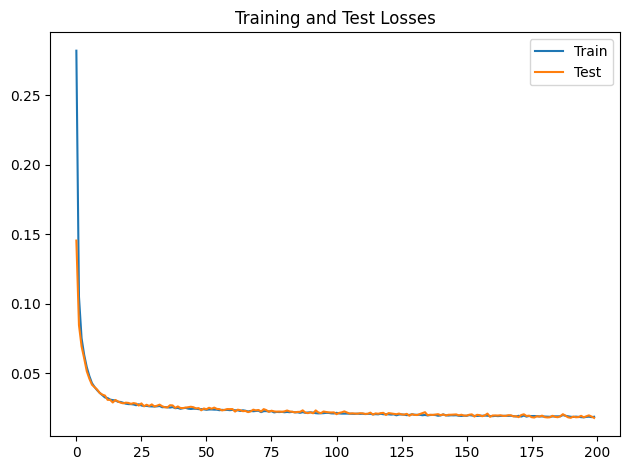

In [13]:
plt.figure()
plt.title('Training and Test Losses')
plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), test_losses, label='Test')
plt.legend()
plt.tight_layout()

### Results

In [17]:
class ConditionalDiffusionBackwardProcess:
    def __init__(
            self,
            *,
            model: MNISTConditionalDiffusionBackwardNetwork,
            beta_scheduler: BetaScheduler,
            w: float, device: str) -> None:
        self._model = model
        self._beta_scheduler = beta_scheduler
        self._device = device
        self._w = w

    def __call__(self, *, noisy_img: torch.Tensor, class_labels: torch.Tensor, time_step: int):
        return self.backward(noisy_img=noisy_img, class_labels=class_labels, time_step=time_step)

    @torch.no_grad()
    def backward(self, *, noisy_img: torch.Tensor, class_labels: torch.Tensor, time_step: int) -> torch.Tensor:
        """
        Perform diffusion backward process (the sampling algorithm in the paper).

        Parameters
        ==========
        noisy_img: torch.Tensor
            Noisy images, a tensor of shape (N, C, H, W) for batched input or (C, H, W) for unbatched input.
        class_labels: torch.Tensor
            Class labels to guide the reverse generation process, can be a tensor of shape
            (N, C, H, W) for batched input or (C, H, W) for unbatched input.
        time_step: int
            Time step of all images.
        """
        self._model.eval()
        is_batched_input = len(noisy_img.shape) == 4
        if is_batched_input:
            batch_size = noisy_img.shape[0]
            time_steps = torch.tensor([time_step]*batch_size)
        else:
            noisy_img = noisy_img[None, ...]
            time_steps = torch.tensor([time_step])

        # Move tensors to the desired device.
        noisy_img = noisy_img.to(self._device)
        time_steps = time_steps.to(self._device)

        # Predict noises.
        conditional_pred_noise = self._model(
            noisy_img,
            time_steps=time_steps,
            class_labels=class_labels,
            class_masks=torch.ones_like(class_labels, device=self._device, dtype=bool))
        unconditional_pred_noise = self._model(
            noisy_img,
            time_steps=time_steps,
            class_labels=class_labels,
            class_masks=torch.zeros_like(class_labels, device=self._device, dtype=bool))

        # Calculate noise.
        noisy_img = noisy_img.cpu()
        time_steps = time_steps.cpu()
        pred_noise = ((self._w + 1) * conditional_pred_noise
                      - self._w * unconditional_pred_noise).cpu()
        means = self._means(noisy_img, pred_noise, time_steps)

        if time_step == 0:
            return means if is_batched_input else means[0]
        else:
            posterior_variances = self._posterior_variances(time_steps)
            random_noise = torch.randn_like(noisy_img)

            # print(torch.sqrt(posterior_variances))
            x = means + random_noise * torch.sqrt(posterior_variances)
            return x if is_batched_input else x[0]

    def _means(self, noisy_img: torch.Tensor, pred_noise: torch.Tensor, time_steps: torch.Tensor):
        """
        Calculate mean.
        """
        # TODO: how to handle time_steps = 0?
        sqrt_alpha_recip = 1. / torch.sqrt(self._beta_scheduler.alpha(time_steps))
        sqrt_1_minus_alpha_bar = self._beta_scheduler.sqrt_1_minus_alpha_bar(time_steps)
        beta = self._beta_scheduler.beta(time_steps)

        return sqrt_alpha_recip * (noisy_img - beta * pred_noise / sqrt_1_minus_alpha_bar)

    def _posterior_variances(self, time_steps: torch.Tensor) -> torch.Tensor:
        """
        Calculate posterior variances.

        Parameters
        ==========
        time_steps: torch.Tensor
            Time steps, can be a scalar tensor or a tensor of shape (N,).
        """
        # TODO: how to handle time_steps = 0?
        beta = self._beta_scheduler.beta(time_steps)
        one_minus_alpha_bar_t = self._beta_scheduler.one_minus_alpha_bar(time_steps)
        one_minus_alpha_bat_t_1 = self._beta_scheduler.one_minus_alpha_bar(time_steps - 1)
        return beta * one_minus_alpha_bat_t_1 / one_minus_alpha_bar_t

9


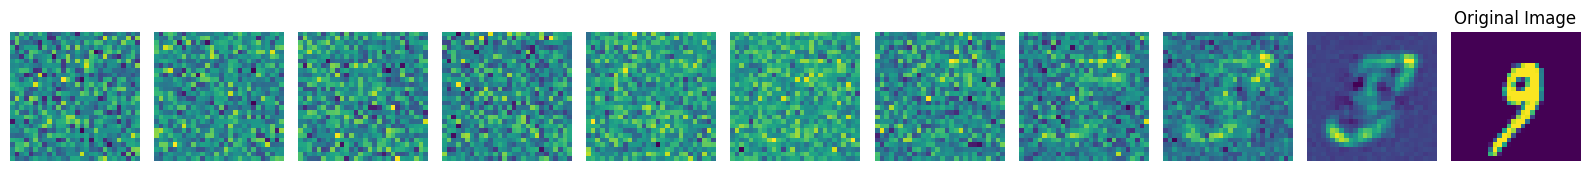

In [21]:
W = 5
backward_process = ConditionalDiffusionBackwardProcess(
    model=model,
    beta_scheduler=beta_scheduler,
    w=W,
    device=device)

original_img, y = mnist_test_ds[1000]
print(y)
noisy_img, _ = forward_process.forward(
    original_img, torch.tensor(forward_process.max_time_steps - 1))
recovered_imgs = []
recovered_img = torch.randn_like(noisy_img)
for i in reversed(range(forward_process.max_time_steps)):
    recovered_img = backward_process.backward(
        noisy_img=recovered_img,
        class_labels=torch.tensor(4),
        time_step=i)

    if i % 20 == 0:
        recovered_imgs.append(recovered_img)

fig, axes = plt.subplots(ncols=len(recovered_imgs) + 1, figsize=(16, 4))
for ax, img in zip(axes, recovered_imgs):
    cs = ax.imshow(img[0])
    # fig.colorbar(cs, ax=ax)
    ax.axis('off')

axes[-1].imshow(original_img[0])
axes[-1].set_title('Original Image')
axes[-1].axis('off')
fig.tight_layout()